In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle

# Save Results

## Load mlflow runs

In [2]:
results_dir = Path.cwd().parent / "results" / "smd"
os.makedirs(results_dir, exist_ok=True)

In [5]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()


In [6]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF',
 'sphere-BatchCoHiRF-DBSCAN-1iter',
 'sphere-DBSCAN',
 'sphere-CoHiRF-DBSCAN',
 'real-ari-BatchCoHiRF-1iter',
 'real-ari-AverageAgglomerativeClustering',
 'real-ari-BatchCoHiRF-DBSCAN-1iter',
 'real-ari-AffinityPropagation',
 'real-ari-BatchCoHiRF-SC-SRGF',
 'real-ari-CoHiRF-DBSCAN',
 'real-ari-CoHiRF-KernelRBF',
 'real-ari-CoHiRF',
 'real-ari-CompleteAgglomerativeClustering',
 'real-ari-DBSCAN',
 'real-ari-HDBSCAN',
 'real-ari-IRFLLRR',
 'real-ari-KMeans',
 'real-ari-MeanShift',
 'real-ari-OPTICS',
 'real-ari-Proclus',
 'real-ari-SingleAgglomerativeClustering',
 'real-ari-SpectralClustering',
 'real-ari-SpectralSubspaceRandomization',
 'real-ari-WardAgglomerativeClustering',
 'real-adjusted_mutual_info-BatchCoHiRF-DBSCAN-1iter',
 'real-adjusted_mutual_info-DBSCAN',
 'real-adjusted_mutual_info-BatchCoHiRF-SC-SRGF',
 'real-adjusted_mutual_info-Comple

In [7]:
experiments_names = [exp for exp in experiment_names if exp.startswith('smd')]

In [8]:
experiments_names

['smd-CoHiRF-1000',
 'smd-KMeans',
 'smd-CoHiRF',
 'smd-CoHiRF-top-down-inv',
 'smd-CoHiRF-top-down']

In [9]:
params_columns = [
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "hpo_seed",
    "distance",
    "best/child_run_id",
]

In [10]:
latest_metrics_columns = [
    "fit_model_return_elapsed_time",
    # "best_n_clusters_",
    # "best_rand_score",
    # "best_adjusted_rand",
    # "best_mutual_info",
    # "best_adjusted_mutual_info",
    # "best_normalized_mutual_info",
    # "best_homogeneity_completeness_v_measure",
    # "best_silhouette",
    # "best_calinski_harabasz_score",
    # "best_davies_bouldin_score",
    # "best_inertia_score",
    # "best_homogeneity",
    # "best_completeness",
    # "best_v_measure",
    "best/n_clusters_",
    "best/rand_score",
    "best/adjusted_rand",
    "best/mutual_info",
    "best/adjusted_mutual_info",
    "best/normalized_mutual_info",
    "best/homogeneity_completeness_v_measure",
    "best/silhouette",
    "best/calinski_harabasz_score",
    # "best/davies_bouldin_score",
    # "best/inertia_score",
    "best/homogeneity",
    "best/completeness",
    "best/v_measure",
	"best/elapsed_time",
]

In [11]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'mlflow.parentRunId',
    # 'best_child_run_id',
]

In [12]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [13]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [14]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)


In [15]:
# df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model_nickname'] = df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model']
# df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_unified'] = df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_dataset']
# columns_best_ = [col for col in df_runs_raw.columns if col.startswith('best_')]
# for col in columns_best_:
# 	col_slash = col.replace('best_', 'best/')
# 	df_runs_raw.loc[df_runs_raw[col].isna(), col] = df_runs_raw.loc[df_runs_raw[col].isna(), col_slash]

In [16]:
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [17]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['mlflow.parentRunId'].isna()]

In [18]:
df_runs_raw_parents

,status,start_time,end_time,best/child_run_id,distance,hpo_seed,model,n_centers,n_features_dataset,n_samples,...,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
000d727bc08541978bf664617fb0a417,FINISHED,1761308875482,1.761309e+12,fb6ce12df86948c98c8c47390fab5a15,31.622777,4,KMeans,5,1000,1000,...,1.609438,7.0,0.938839,0.974738,0.137376,0.938839,85.769584,NaN,NaN,False
000dbf08aa7640c99d51ee945b8dcc7d,FAILED,1761774209225,1.761774e+12,NaN,9.000000,3,CoHiRF-top-down,5,1000000,100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unable to allocate 7.28 TiB for an array with ...,NaN,True
001fb5117234417e9bf2f444924cf600,FINISHED,1761763969505,1.761767e+12,7276e90c48804cdc80ea41b64411e5ad,6.000000,3,CoHiRF-top-down,5,10000,10000,...,1.145192,4.0,0.775867,0.896457,0.000325,0.775867,2777.763299,NaN,NaN,False
0023293546004f1cbd9318bbb26a803c,FAILED,1761743350920,1.761743e+12,NaN,2.000000,2,CoHiRF-1000,5,1000000,100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unable to allocate 7.28 TiB for an array with ...,NaN,True
0025df2628bd423a93e005db1bbd4987,FINISHED,1761773064407,1.761773e+12,0d5fd0d03e2e42dc9bc0138c87f8d54e,8.000000,4,CoHiRF,5,1000,10000,...,1.605794,214.0,0.970115,0.995878,-0.018702,0.970115,393.450132,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff781b815db84988b3db79203580a542,FINISHED,1761761189075,1.761762e+12,cc05aa93ba8f4103a7c973031e67bd26,6.000000,3,CoHiRF-1000,5,1000,10000,...,1.587400,263.0,0.960535,0.994556,-0.027419,0.960535,353.542580,NaN,NaN,False
ff7a57d29c084cf5a89fdd6641fda23f,FINISHED,1761776669988,1.761777e+12,d49d228aa3f242a98079f1db16cb0eb0,10.000000,4,KMeans,5,1000,10000,...,1.609438,6.0,0.958894,0.980128,0.016197,0.958894,145.034211,NaN,NaN,False
ffb6bf62ad794f7eb0089da2463c6d3d,RUNNING,1761770700971,NaN,NaN,8.000000,3,CoHiRF,5,10000,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [19]:
non_duplicate_columns = [
    # "model_nickname",
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best/adjusted_rand"]).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")
df_runs_parents['distance'] = df_runs_parents['distance'].round(5)

# Missing

In [20]:
model_nickname = df_runs_parents['model'].unique().tolist()
model_nickname.sort()
model_nickname

['CoHiRF', 'CoHiRF-1000', 'CoHiRF-top-down', 'CoHiRF-top-down-inv', 'KMeans']

In [21]:
model_nickname = [
    "CoHiRF",
    "KMeans",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
]

In [22]:
# create df with expected combinations
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = 1000
n_features_dataset = 10
n_centers = 5
distance_mult = [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance_mult:
        for seed in seeds:
            combination = {
                "model": model,
                "n_samples": n_samples,
                "n_features_dataset": n_features_dataset,
                "distance_mult": d,
                "n_centers": n_centers,
                "seed_dataset": seed,
                "hpo_seed": seed,
            }
            combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
combinations_df["distance"] = combinations_df["distance_mult"] * 2 * combinations_df["n_features_dataset"] ** 0.5
combinations_df = combinations_df.drop(columns=["distance_mult"])
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,n_centers,seed_dataset,hpo_seed_x,distance,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge
0,CoHiRF,1000,10,5,0,0,1.897367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,CoHiRF,1000,10,5,1,1,1.897367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,CoHiRF,1000,10,5,2,2,1.897367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,CoHiRF,1000,10,5,3,3,1.897367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,CoHiRF,1000,10,5,4,4,1.897367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,KMeans,1000,10,5,0,0,12.649111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
196,KMeans,1000,10,5,1,1,12.649111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
197,KMeans,1000,10,5,2,2,12.649111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
198,KMeans,1000,10,5,3,3,12.649111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [23]:
# create df with expected combinations
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = 1000
n_features_dataset = 100
n_centers = 5
distance_mult = [0.1, 0.2, 0.05, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance_mult:
        for seed in seeds:
            combination = {
                "model": model,
                "n_samples": n_samples,
                "n_features_dataset": n_features_dataset,
                "distance_mult": d,
                "n_centers": n_centers,
                "seed_dataset": seed,
                "hpo_seed": seed,
            }
            combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
combinations_df["distance"] = combinations_df["distance_mult"] * 2 * combinations_df["n_features_dataset"] ** 0.5
combinations_df = combinations_df.drop(columns=["distance_mult"])
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,n_centers,seed_dataset,hpo_seed_x,distance,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge


In [24]:
# create df with expected combinations
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = 1000
n_features_dataset = 1000
n_centers = 5
distance_mult = [0.1, 0.2, 0.05, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance_mult:
        for seed in seeds:
            combination = {
                "model": model,
                "n_samples": n_samples,
                "n_features_dataset": n_features_dataset,
                "distance_mult": d,
                "n_centers": n_centers,
                "seed_dataset": seed,
                "hpo_seed": seed,
            }
            combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
combinations_df["distance"] = combinations_df["distance_mult"] * 2 * combinations_df["n_features_dataset"] ** 0.5
combinations_df = combinations_df.drop(columns=["distance_mult"])
combinations_df["distance"] = combinations_df["distance"].round(5)
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,n_centers,seed_dataset,hpo_seed_x,distance,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge


In [25]:
# create df with expected combinations
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = 1000
n_features_dataset = 10000
n_centers = 5
distance_mult = [0.1, 0.2, 0.05, 0.3, 0.5, 0.7]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance_mult:
        for seed in seeds:
            combination = {
                "model": model,
                "n_samples": n_samples,
                "n_features_dataset": n_features_dataset,
                "distance_mult": d,
                "n_centers": n_centers,
                "seed_dataset": seed,
                "hpo_seed": seed,
            }
            combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
combinations_df["distance"] = combinations_df["distance_mult"] * 2 * combinations_df["n_features_dataset"] ** 0.5
combinations_df = combinations_df.drop(columns=["distance_mult"])
combinations_df["distance"] = combinations_df["distance"].round(5)
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,n_centers,seed_dataset,hpo_seed_x,distance,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge


In [26]:
# create df with expected combinations
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = 1000
n_features_dataset = 10000
n_centers = 5
distance = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance:
        for seed in seeds:
            combination = {
                "model": model,
                "n_samples": n_samples,
                "n_features_dataset": n_features_dataset,
                "distance": d,
                "n_centers": n_centers,
                "seed_dataset": seed,
                "hpo_seed": seed,
            }
            combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
combinations_df["distance"] = combinations_df["distance"].round(5)
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,distance,n_centers,seed_dataset,hpo_seed_x,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge


In [29]:
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = [10000]
n_features_dataset_mult = [0.1, 1]
n_centers = 5
distance = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance:
        for seed in seeds:
            for n_features_dataset_multiplier in n_features_dataset_mult:
                for n in n_samples:
                    combination = {
                        "model": model,
                        "n_samples": n,
                        "n_features_dataset": int(n * n_features_dataset_multiplier),
                        "distance": d,
                        "n_centers": n_centers,
                        "seed_dataset": seed,
                        "hpo_seed": seed,
                    }
                    combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,distance,n_centers,seed_dataset,hpo_seed_x,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge
11,CoHiRF,10000,10000,3.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
13,CoHiRF,10000,10000,3.0,5,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
17,CoHiRF,10000,10000,3.0,5,3,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
21,CoHiRF,10000,10000,4.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,CoHiRF,10000,10000,4.0,5,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,KMeans,10000,10000,7.0,5,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
417,KMeans,10000,10000,7.0,5,3,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
419,KMeans,10000,10000,7.0,5,4,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
421,KMeans,10000,10000,8.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [27]:
models_names = [
    "CoHiRF",
    "CoHiRF-1000",
    "CoHiRF-top-down",
    "CoHiRF-top-down-inv",
    "KMeans",
]
n_samples = [10000, 100000]
n_features_dataset_mult = [0.1, 1, 10]
n_centers = 5
distance = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
seeds = [i for i in range(5)]
combinations = []
for model in models_names:
    for d in distance:
        for seed in seeds:
            for n_features_dataset_multiplier in n_features_dataset_mult:
                for n in n_samples:
                    combination = {
                        "model": model,
                        "n_samples": n,
                        "n_features_dataset": int(n * n_features_dataset_multiplier),
                        "distance": d,
                        "n_centers": n_centers,
                        "seed_dataset": seed,
                        "hpo_seed": seed,
                    }
                    combinations.append(combination)
combinations_df = pd.DataFrame(combinations)
unique_columns = [
    "model",
    "n_samples",
    "n_features_dataset",
    "n_centers",
    "distance",
    "seed_dataset",
]
# compare combinations_df with df_runs_parents to get missing combinations
df_missing = combinations_df.merge(
    df_runs_parents,
    on=unique_columns,
    how="left",
    indicator=True,
)
df_missing = df_missing.loc[df_missing["_merge"] == "left_only"]
df_missing

,model,n_samples,n_features_dataset,distance,n_centers,seed_dataset,hpo_seed_x,status,start_time,end_time,...,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,EXCEPTION,mlflow.parentRunId,raised_exception,_merge
1,CoHiRF,100000,10000,2.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,CoHiRF,100000,100000,2.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,CoHiRF,10000,100000,2.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,CoHiRF,100000,1000000,2.0,5,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,CoHiRF,100000,10000,2.0,5,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343,KMeans,100000,1000000,10.0,5,3,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1345,KMeans,100000,10000,10.0,5,4,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1347,KMeans,100000,100000,10.0,5,4,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1348,KMeans,10000,100000,10.0,5,4,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [26]:
# # Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
# df_missing_with_exception = df_missing.merge(
#     df_runs_raw_parents[non_duplicate_columns + ["raised_exception"]],
#     how="left",
#     left_on=["model", "n_random", "seed_dataset", "n_informative"],
#     right_on=["model", "n_random", "seed_dataset", "n_informative"],
# )
# df_missing_with_exception[["model", "n_random", "seed_dataset", "n_informative", "raised_exception"]]

In [27]:
df_missing = df_missing[unique_columns]
df_missing["hpo_seed"] = df_missing["seed_dataset"]
df_missing.to_csv(results_dir / "df_missing.csv")

# Plots

In [28]:
def plot_results(df):
    plt.style.use("seaborn-v0_8-whitegrid")
    with mpl.rc_context(
        rc={
            "figure.constrained_layout.use": True,
            "savefig.bbox": "tight",
            "figure.figsize": (12, 7),
            "legend.loc": "upper left",
            "legend.frameon": True,
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 15,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "axes.grid": True,
            "grid.color": "grey",
            "grid.alpha": 0.3,
        }
    ):
        fig, axs = plt.subplots(2, 1, sharex=True)
        axs = axs.flatten()
        palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
        # Time plot
        ax = sns.lineplot(
            data=df,
            x="Distance",
            y="Time (s)",
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[0],
            palette=palette,
        )
        # ax.set_yscale("log")
        ax.set_ylabel("Time (s)")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        # ARI plot
        ax2 = sns.lineplot(
            data=df,
            x="Distance",
            y="ARI",
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[1],
            palette=palette,
        )
        ax2.set_ylabel("Adjusted Rand Index (ARI)")
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
        # ax2.set_xscale("log")
        # Remove duplicate legends
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
        ax.get_legend().remove()
        ax2.get_legend().remove()
        plt.xlabel("Distance")
        plt.tight_layout()
        return fig, axs

## HPO Time

/tmp/ipykernel_1467/2792136935.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


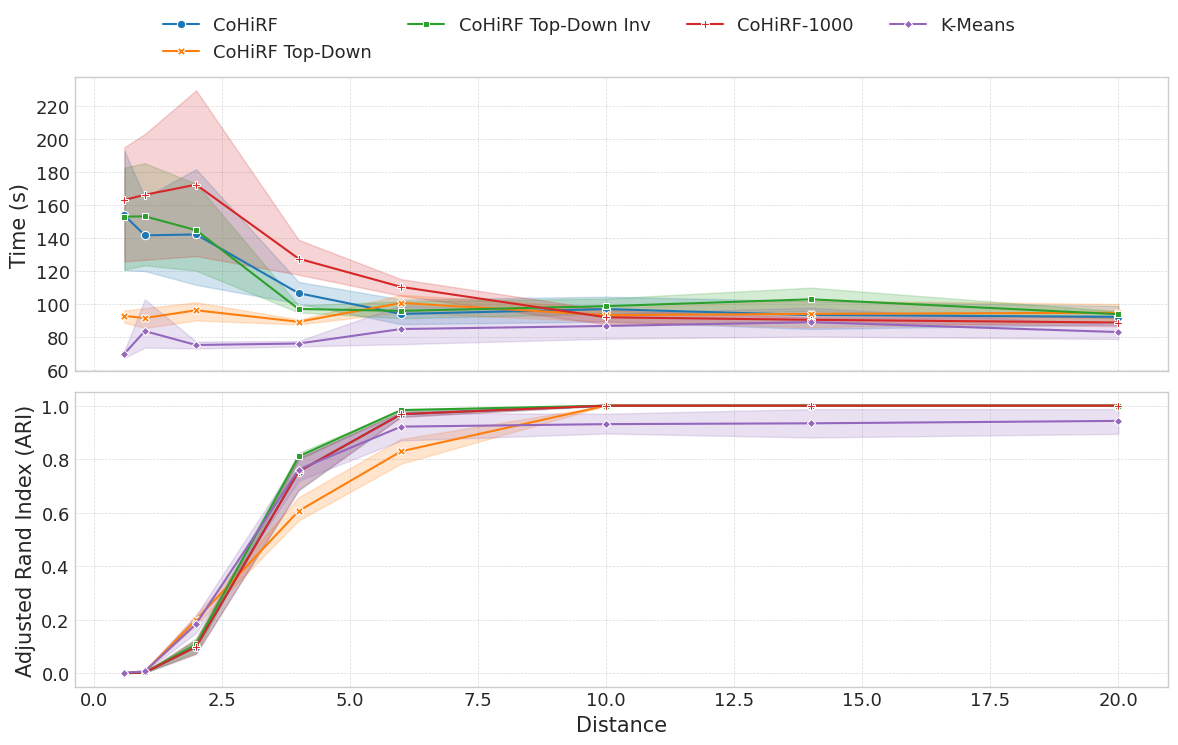

In [32]:
df = df_runs_parents.copy()
n_samples = 1000
n_features_dataset = 100
n_centers = 5
models_names = {
    "CoHiRF": "CoHiRF",
    "CoHiRF-1000": "CoHiRF-1000",
    "CoHiRF-top-down": "CoHiRF Top-Down",
    "CoHiRF-top-down-inv": "CoHiRF Top-Down Inv",
    "KMeans": "K-Means",
}
df = df.loc[
    (df["n_samples"] == n_samples)
    & (df["n_features_dataset"] == n_features_dataset)
    & (df["n_centers"] == n_centers)
    & (df["model"].isin(models_names.keys()))
	& (df["distance"] <= 20.0)
]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "distance": "Distance",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

fig, axs = plot_results(df)
plt.show()

## Best Time

In [30]:
# df = df_runs_parents.copy()
# n_informative = 3
# n_samples = 1000
# n_classes = 5
# class_sep = 3 * (n_informative**0.5)
# models_names = {
#     "CoHiRF": "CoHiRF",
#     "CoHiRF-1000": "CoHiRF-1000",
#     "CoHiRF-top-down": "CoHiRF Top-Down",
#     "CoHiRF-top-down-inv": "CoHiRF Top-Down Inv",
#     "KMeans": "K-Means",
# }
# df = df.loc[
#     (df["n_informative"] == n_informative)
#     & (df["n_samples"] == n_samples)
#     & (df["n_classes"] == n_classes)
#     & (df["class_sep"] == class_sep)
#     & (df["model"].isin(models_names.keys()))
# ]
# df = df.replace({"model": models_names})
# df = df.sort_values(by="model")
# df = df.rename(
#     columns={
#         "best/elapsed_time": "Time (s)",
#         "max_memory_used": "Memory (MB)",
#         "n_samples": "Number of samples",
#         "n_random": "Number of Non Informative Features",
#         "model": "Model",
#         "best/adjusted_rand": "ARI",
#     }
# )

# fig, axs = plot_results(df)
# plt.show()

# Debug and explore

df_runs_raw.model_nickname.unique()

df = df_runs_raw.copy()
df = df.loc[df["model_nickname"].isin(["BatchCoHiRF", "BatchCoHiRF-1iter", "BatchCoHiRF-SC-SRGF"])]

runs_to_delete = list(df.index)
runs_to_delete

run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    